In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

#### *Premier modèle sans optimisation*

In [82]:
def encodage(df):
    code = {"AAA" : 10,
            "AA" : 9,
            "A" : 8,
            "BBB" : 7,
            "BB" : 6,
            "B" : 5,
            "CCC" : 4,
            "CC" : 3,
            "C" : 2}
    if "Credit Rating" in df.columns:
        df["Credit Rating"] = df["Credit Rating"].map(code)     
    return df

def features(df):
    df['Profitability_Ratio'] = pd.to_numeric(df['Profit']) / pd.to_numeric(df['Revenue'])
    df["Profit_per_employee"] = df["Profit"]/df["Employee Count"]
    df["RnD_Spend_to_revenue"] = df["Research and Development Spend"]/pd.to_numeric(df["Revenue"])
    df["Earnings_to_Market_Cap"] = df["Profit"]/df["Market Capitalization"]
    return df


def processing(df):
    df = features(df)
    df = encodage(df)
    X = df.drop("Risk", axis=1)
    y = df["Risk"]
    return X, y

def make_predictions(input_data, model, X_train, y_train, encoder=None, scaler=None):
    input_data_copy = input_data.copy()
    if encoder:
        input_data_copy = encoder(input_data_copy)
    feature_names = X_train.columns.tolist()
    X_input = input_data_copy[feature_names]
    if scaler:
        X_input = scaler.transform(X_input)
    predictions = model.predict(X_input)
    input_data_copy["Risk"] = predictions
    return input_data_copy

In [3]:
#Importation du dataset
data = pd.read_csv("training_dataset.csv")
data.head()

,Company ID,Revenue,Employee Count,Credit Rating,Risk,Expenses,Research and Development Spend,Profit,Debt-to-Equity Ratio,Price-to-Earnings Ratio,Market Capitalization
0,1050,108.507764,5695,B,1,13.614721,33.490353,94.893043,1.745759,20.659128,2159.665865
1,303,316.254049,5490,B,0,235.302857,16.271908,80.951192,0.724783,27.421956,1828.014221
2,4253,235.722107,8164,BBB,1,195.839247,6.210687,39.882860,1.481972,8.830808,354.006752
3,1584,298.706744,9295,A,0,271.777163,6.333781,26.929581,1.685455,26.695698,598.612673
4,379,425.787393,1431,BBB,0,340.989094,28.933570,84.798299,1.731434,16.101618,1602.984505


In [4]:
X, y = processing(data)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [8]:
y_pred_rf = rf_model.predict(X_test_scaled)

In [9]:
accuracy_rf = metrics.accuracy_score(y_test, y_pred_rf)
precision_rf = metrics.precision_score(y_test, y_pred_rf)
recall_rf = metrics.recall_score(y_test, y_pred_rf)

print(f'Random Forest Accuracy: {accuracy_rf}')
print(f'Random Forest Precision: {precision_rf}')
print(f'Random Forest Recall: {recall_rf}')

Random Forest Accuracy: 0.70625
Random Forest Precision: 0.75
Random Forest Recall: 0.04938271604938271


#### *Première optimastion de l'algorithme*

In [10]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [11]:
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='recall')

In [12]:
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

In [13]:
accuracy_best_rf = metrics.accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = metrics.precision_score(y_test, y_pred_best_rf)
recall_best_rf = metrics.recall_score(y_test, y_pred_best_rf)

print(f'Best Random Forest Accuracy: {accuracy_best_rf}')
print(f'Best Random Forest Precision: {precision_best_rf}')
print(f'Best Random Forest Recall: {recall_best_rf}')

print(f'Best Random Forest Hyperparameters: {best_params}')

Best Random Forest Accuracy: 0.70375
Best Random Forest Precision: 0.7142857142857143
Best Random Forest Recall: 0.0411522633744856
Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


#### *Visualisations*

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

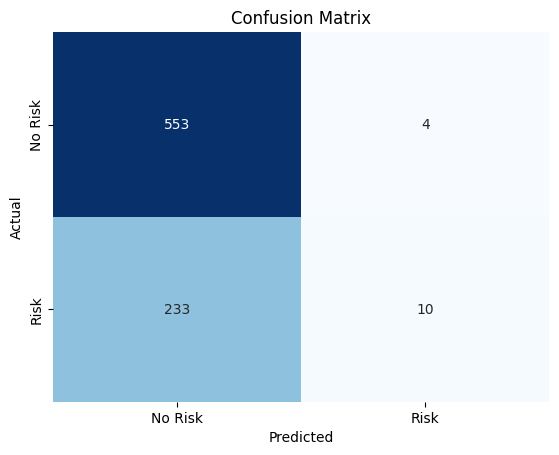

In [16]:
cm = confusion_matrix(y_test, y_pred_best_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Le modèle a correctement prédit 553 points comme étant "*No risk*" (0). <br>
Le modèle a prédit 4 points comme "*Risk*" (1) mais qui sont réellement "*No Risk*" (0). <br>
Le modèle a prédit 233 points comme "*No Risk*" (0) mais qui sont réellement "*Risk*" (1). <br>
Le modèle a correctement prédit 10 points comme étant "*Risk*" (1). <br>

Le bilan est clair : notre modèle a une lacune dans la prédiction des points "*Risk*" (1).

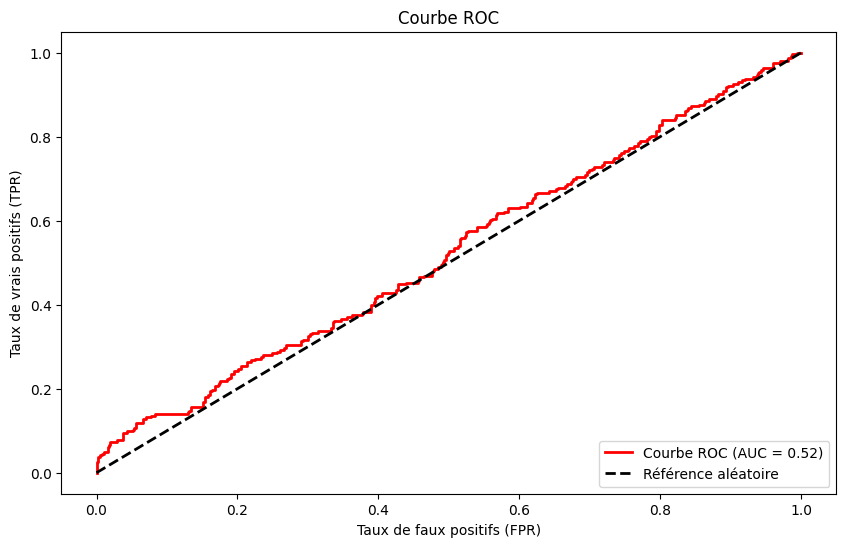

In [73]:
# Calcul des taux de faux positifs (FPR) et vrais positifs (TPR)
fpr, tpr, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Référence aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

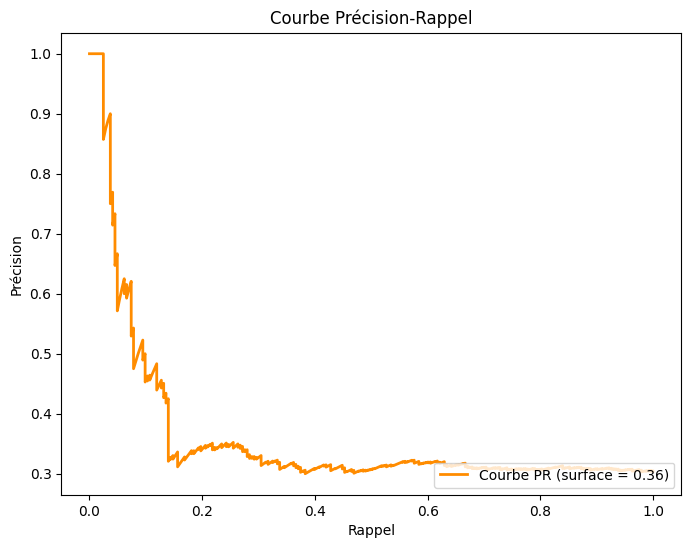

In [22]:
# Calculer la courbe précision-rappel
precision, recall, _ = precision_recall_curve(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='Courbe PR (surface = %0.2f)' % pr_auc)
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe Précision-Rappel')
plt.legend(loc='lower right')
plt.show()

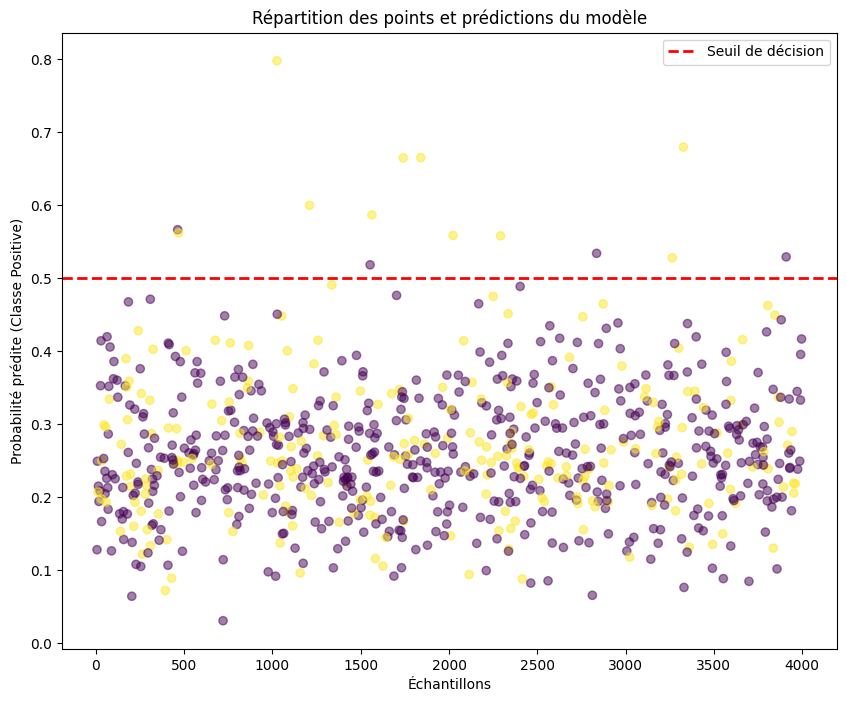

In [23]:
# Prédictions du modèle sur l'ensemble de test
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]

df_plot = pd.DataFrame({'Actual': y_test, 'Predicted Probability': y_pred_proba})

plt.figure(figsize=(10, 8))
plt.scatter(df_plot.index, df_plot['Predicted Probability'], c=df_plot['Actual'], cmap='viridis', marker='o', alpha=0.5)
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=2, label='Seuil de décision')
plt.xlabel('Échantillons')
plt.ylabel('Probabilité prédite (Classe Positive)')
plt.title('Répartition des points et prédictions du modèle')
plt.legend()
plt.show()

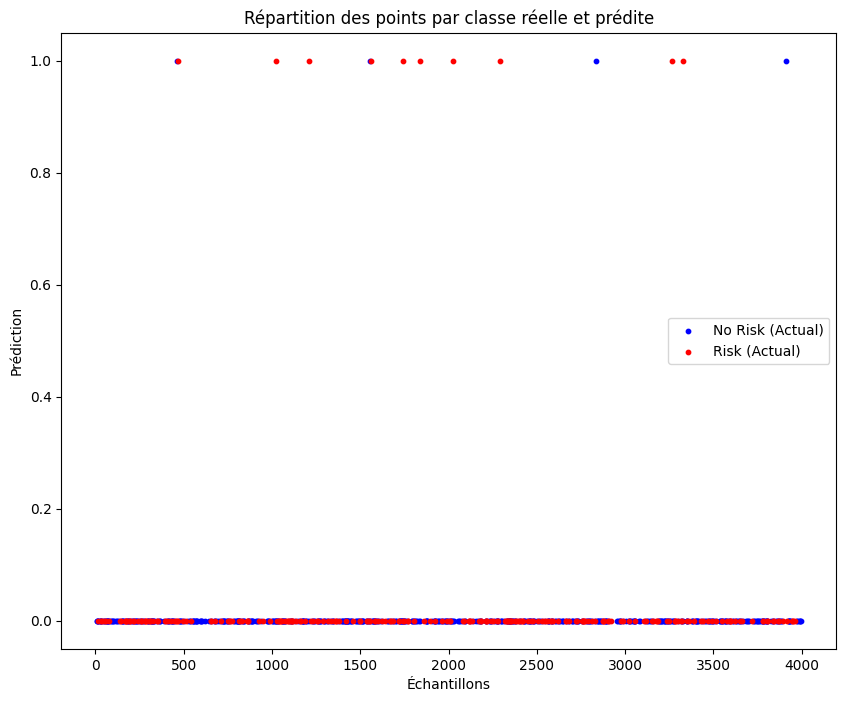

In [27]:
df_plot = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best_rf})

plt.figure(figsize=(10, 8))
plt.scatter(df_plot.index[df_plot['Actual'] == 0], df_plot.loc[df_plot['Actual'] == 0, 'Predicted'], 
            color='blue', label='No Risk (Actual)', s=10)
plt.scatter(df_plot.index[df_plot['Actual'] == 1], df_plot.loc[df_plot['Actual'] == 1, 'Predicted'], 
            color='red', label='Risk (Actual)', s=10)
plt.xlabel('Échantillons')
plt.ylabel('Prédiction')
plt.title('Répartition des points par classe réelle et prédite')
plt.legend()
plt.show()

L'ordonnée 0 représente la classe "No risk" ou la valeur 0 de la classe "Risk", 1 représente la classe "*Risk*". <br>
On remarque que le modèle se trompe un grand nombre de fois sur la determination des points "Risk" en rouge. Ce qui confirme le resultat de la matrice de confusion.

#### *Perfection du modèle*

##### *Déséquilibre des classes* 

Risk
0    2948
1    1052
Name: count, dtype: int64


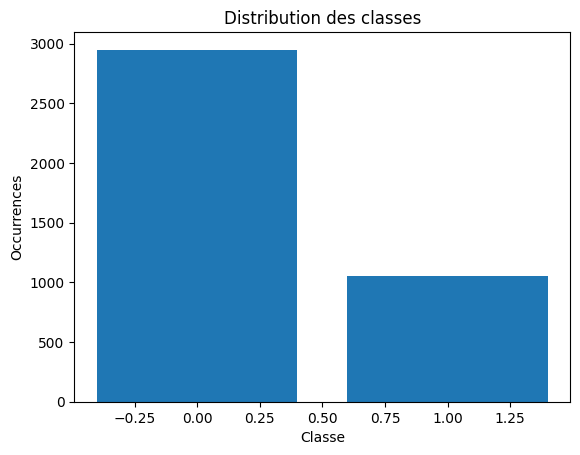

In [30]:
counts = data['Risk'].value_counts()
print(counts)

plt.bar(counts.index, counts.values)
plt.xlabel('Classe')
plt.ylabel('Occurrences')
plt.title('Distribution des classes')
plt.show()

On observe un léger déséquilibre des classes. La classe 0 *No Risk* est plus représenter que la classe 1 *Risk*
On peut donc tester plusieurs techniques par exemple <br> (Over-sampling, Under-sampling, Data Augmentation). Mais ce ne sera pas le cas ici. On se focalise uniquement sur nos données.

In [50]:
class_weights = {0: 1, 1: 7}

Ici on augmente le poids pour la classe *Risk* (1) par rapport à la classe *No Risk* (0). <br>
Cela signifie qu'on donne plus de poids aux erreurs de classification de la classe "Risk" dans l'objectif de réduire les faux négatifs. (très présents) <br>
D'après la recherche de GridSearch précédente on peut définir le dictionnaire suivant : <br>
Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}

##### *Definition du nouveau modèle*

In [56]:
param_grid_2 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]  
}


In [57]:
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid_2, cv=5, scoring="recall", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Meilleurs hyperparamètres:", grid_search.best_params_)

Meilleurs hyperparamètres: {'bootstrap': False, 'class_weight': {0: 1, 1: 5}, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [58]:
best_params_2 = grid_search.best_params_
best_clf = grid_search.best_estimator_
y_pred_best_clf = best_clf.predict(X_test_scaled)

In [59]:
accuracy_clf = metrics.accuracy_score(y_test, y_pred_best_clf)
precision_clf = metrics.precision_score(y_test, y_pred_best_clf )
recall_clf = metrics.recall_score(y_test, y_pred_best_clf )

print(f'Best Random Forest Accuracy: {accuracy_clf}')
print(f'Best Random Forest Precision: {precision_clf}')
print(f'Best Random Forest Recall: {recall_clf}')

Best Random Forest Accuracy: 0.34375
Best Random Forest Precision: 0.30578512396694213
Best Random Forest Recall: 0.9135802469135802


##### *Visualisations*

On peut refaire une matrice de confusion pour voir s'il y a des changements ou non

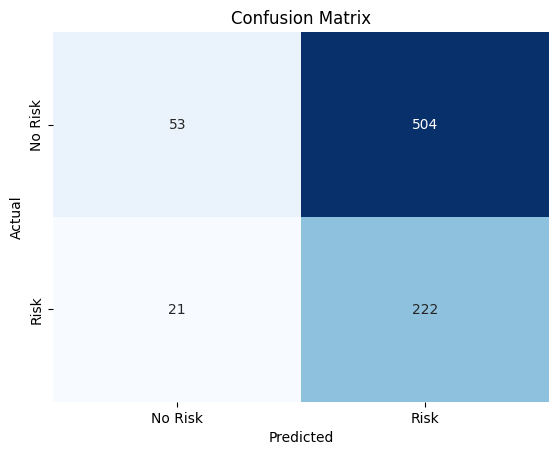

In [60]:
cm_2 = confusion_matrix(y_test, y_pred_best_clf)

sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Le modèle a correctement prédit 53 points comme étant "*No risk*" (0). <br>
Le modèle a prédit 504 points comme "*Risk*" (1) mais qui sont réellement "*No Risk*" (0). <br>
Le modèle a prédit 21 points comme "*No Risk*" (0) mais qui sont réellement "*Risk*" (1). <br>
Le modèle a correctement prédit 222 points comme étant "*Risk*" (1). <br>

A première vue le modèle semble très mauvais, seulement 34 % de précision. Ce qui est un peu logique car on a augmenté le poids de la classe 1 *Risk*. Le modèle se trompe la quasi-totalité du temps pour la classe *No Risk* (0) et créer donc un grand nombre de FP (false poisitve). Mais le nombre de FN (false negative) a grandement diminué. Il est moins grave de prédire qu'une entreprise présente un risque alors que non que l'inverse. 
Cependant on peut continuer pour essayer de perfectionner encore le modèle 

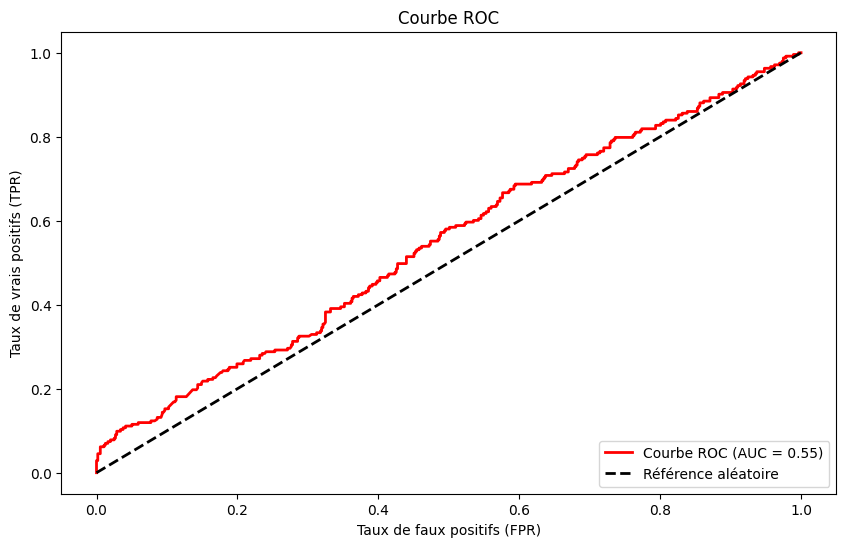

In [67]:
fpr_2, tpr_2, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr_2, tpr_2)

plt.figure(figsize=(10, 6))
plt.plot(fpr_2, tpr_2, color='red', lw=2, label='Courbe ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Référence aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

On a AUC = 0.55 (aire sous la courbe). On est donc un peu au dessus d'un choix aléatoire. Ce qui est un peu mieux que précédement mais cela ne reste pas très satisfaisant. <br>
On peut changer de base et passer du *recall* au *f1-score*, plus adapté aux déséquilibre des classes.

#### *Perfection 2 (f1-score)*

In [11]:
param_grid_3 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]  
}

In [13]:
clf_f1 = RandomForestClassifier()
grid_search_f1 = GridSearchCV(clf_f1, param_grid_3, scoring='f1', cv=5, n_jobs=-1)
grid_search_f1.fit(X_train_scaled, y_train)
print("Meilleurs hyperparamètres:", grid_search_f1.best_params_)

Meilleurs hyperparamètres: {'bootstrap': True, 'class_weight': {0: 1, 1: 5}, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


On a les hyperparamètres suicant : <br> 
{'bootstrap': True, 'class_weight': {0: 1, 1: 5}, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}. <br> On peut donc constuire note "best" estimateur

Best Random Forest Accuracy: 0.50375
Best Random Forest Precision: 0.3441295546558704
Best Random Forest Recall: 0.6995884773662552


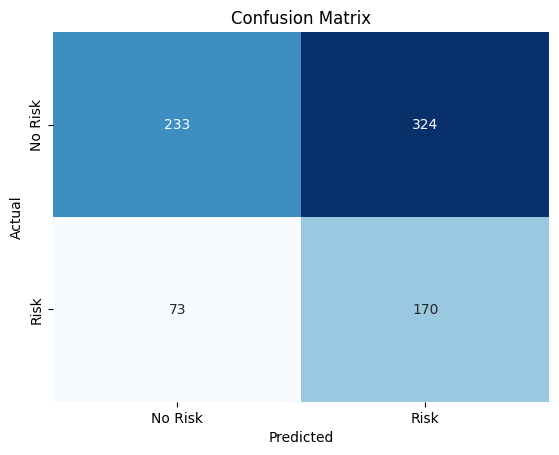

In [50]:
clf_f1_best = RandomForestClassifier(bootstrap=True,
                                    class_weight={0:1, 1:3.5}, 
                                    max_depth=5,
                                    min_samples_leaf=1,
                                    min_samples_split=10,
                                    n_estimators=75)

clf_f1_best.fit(X_train_scaled, y_train)
y_pred_best_clf_f1 = clf_f1_best.predict(X_test_scaled)

accuracy_clf_f1_best = metrics.accuracy_score(y_test, y_pred_best_clf_f1)
precision_clf_f1_best = metrics.precision_score(y_test, y_pred_best_clf_f1 )
recall_clf_f1_best = metrics.recall_score(y_test, y_pred_best_clf_f1 )

print(f'Best Random Forest Accuracy: {accuracy_clf_f1_best}')
print(f'Best Random Forest Precision: {precision_clf_f1_best}')
print(f'Best Random Forest Recall: {recall_clf_f1_best}')

cm_3 = confusion_matrix(y_test, y_pred_best_clf_f1)

sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

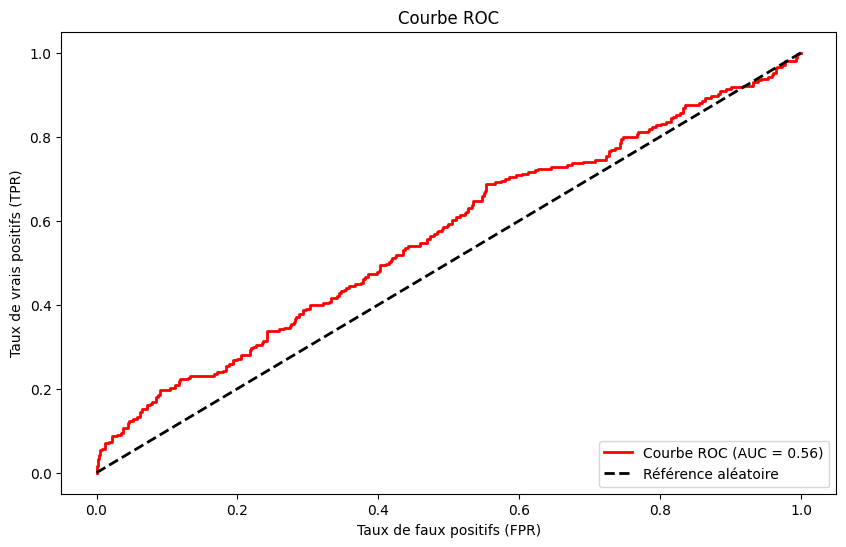

In [81]:
fpr_3, tpr_3, thresholds_2 = roc_curve(y_test, clf_f1_best.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr_3, tpr_3)

plt.figure(figsize=(10, 6))
plt.plot(fpr_3, tpr_3, color='red', lw=2, label='Courbe ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Référence aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [73]:
final_csv = pd.read_csv("final_test.csv")
final_csv = features(final_csv)
final_csv = encodage(final_csv)
final_csv.head()

,Company ID,Revenue,Expenses,Profit,Employee Count,Debt-to-Equity Ratio,Price-to-Earnings Ratio,Research and Development Spend,Market Capitalization,Credit Rating,Profitability_Ratio,Profit_per_employee,RnD_Spend_to_revenue,Earnings_to_Market_Cap
0,2116,160.841713,68.195018,92.646695,427,0.195690,28.614082,8.878047,2425.273325,8,0.576012,0.216971,0.055197,0.038201
1,1941,123.420372,38.462952,84.957419,6520,0.114424,8.774125,20.937636,820.936133,8,0.688358,0.013030,0.169645,0.103488
2,642,228.831666,143.272011,85.559655,5824,0.350365,21.161713,35.046399,2058.404241,9,0.373898,0.014691,0.153154,0.041566
3,2981,275.064531,239.037346,36.027186,4805,1.682174,22.811269,27.000628,754.544105,6,0.130977,0.007498,0.098161,0.047747
4,4862,423.307284,361.579323,61.727961,9073,0.773530,18.618122,17.232549,1320.822085,7,0.145823,0.006803,0.040709,0.046735


In [83]:
predictions = make_predictions(final_csv, clf_f1_best, X_train, y_train, scaler=scaler)

In [84]:
predictions.head(10)

,Company ID,Revenue,Expenses,Profit,Employee Count,Debt-to-Equity Ratio,Price-to-Earnings Ratio,Research and Development Spend,Market Capitalization,Credit Rating,Profitability_Ratio,Profit_per_employee,RnD_Spend_to_revenue,Earnings_to_Market_Cap,Risk
0,2116,160.841713,68.195018,92.646695,427,0.195690,28.614082,8.878047,2425.273325,8,0.576012,0.216971,0.055197,0.038201,0
1,1941,123.420372,38.462952,84.957419,6520,0.114424,8.774125,20.937636,820.936133,8,0.688358,0.013030,0.169645,0.103488,0
2,642,228.831666,143.272011,85.559655,5824,0.350365,21.161713,35.046399,2058.404241,9,0.373898,0.014691,0.153154,0.041566,0
3,2981,275.064531,239.037346,36.027186,4805,1.682174,22.811269,27.000628,754.544105,6,0.130977,0.007498,0.098161,0.047747,1
4,4862,423.307284,361.579323,61.727961,9073,0.773530,18.618122,17.232549,1320.822085,7,0.145823,0.006803,0.040709,0.046735,0
5,932,433.972095,387.498913,46.473181,998,1.607355,15.645429,37.747449,764.506321,9,0.107088,0.046566,0.086981,0.060788,1
6,4744,497.732121,423.010132,74.721989,9689,1.760808,24.308524,7.038281,1595.648456,5,0.150125,0.007712,0.014141,0.046829,1
7,3194,230.697017,194.114415,36.582602,2795,1.657776,26.539759,24.077439,861.395928,4,0.158574,0.013089,0.104368,0.042469,1
8,2282,244.741237,220.455113,24.286125,6083,0.754879,22.151899,43.311974,478.300541,7,0.099232,0.003992,0.176970,0.050776,1
9,4220,200.924771,170.724793,30.199978,3652,1.401586,8.303905,33.792789,286.359338,10,0.150305,0.008269,0.168186,0.105462,1


In [85]:
somme_colonne = predictions['Risk'].sum()

print("Somme de la colonne :", somme_colonne)

Somme de la colonne : 614
